In [1]:
import pandas as pd
import xgboost as xgb

from sklearn.metrics import  accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv('tourneyGames.csv')
le_win = LabelEncoder()
le_team = LabelEncoder()
df['winner']= le_win.fit_transform(df['winner'])
df['TEAM_higher']= le_team.fit_transform(df['TEAM_higher'])
df['TEAM_lower']= le_team.fit_transform(df['TEAM_lower'])
# df = df.drop(columns=['Unnamed: 0','Year','losing_abbr','losing_name','winning_name','POSTSEASON_higher','POSTSEASON_lower','ETO_Avg_higher', 'ETO_Avg_lower','E_diff_higher','E_diff_lower'])

In [3]:
x = df.drop('winner', axis=1)
y = df['winner']

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.27, random_state=42)

XGBoost

In [4]:
params = {
    'objective':'binary:logistic',
    'learning_rate': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 5,
    'gamma': 0.1,
    'scale_pos_weight': 1.86, 
}


In [5]:
dtrain = xgb.DMatrix(data=x_train, label=y_train)
dtest = xgb.DMatrix(data=x_test, label=y_test)

cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    nfold=5,
    early_stopping_rounds=10,
    metrics="aucpr",
    as_pandas=True,
    seed=53
)
cv_results.head()

,train-aucpr-mean,train-aucpr-std,test-aucpr-mean,test-aucpr-std
0,0.861037,0.014876,0.724838,0.090938
1,0.914744,0.010586,0.807760,0.056124
2,0.933587,0.010159,0.858709,0.048500
3,0.944185,0.010465,0.858235,0.033298
4,0.949753,0.007094,0.865541,0.031611


In [6]:
model = xgb.train(params=params, dtrain=dtrain, num_boost_round=50)

Accuracy: 0.9191
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       177
           1       0.92      0.84      0.88        95

    accuracy                           0.92       272
   macro avg       0.92      0.90      0.91       272
weighted avg       0.92      0.92      0.92       272



<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

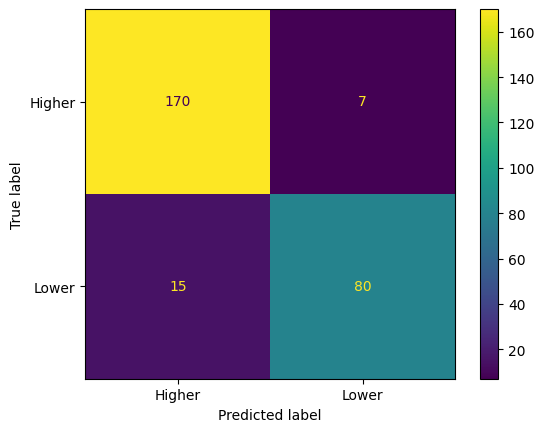

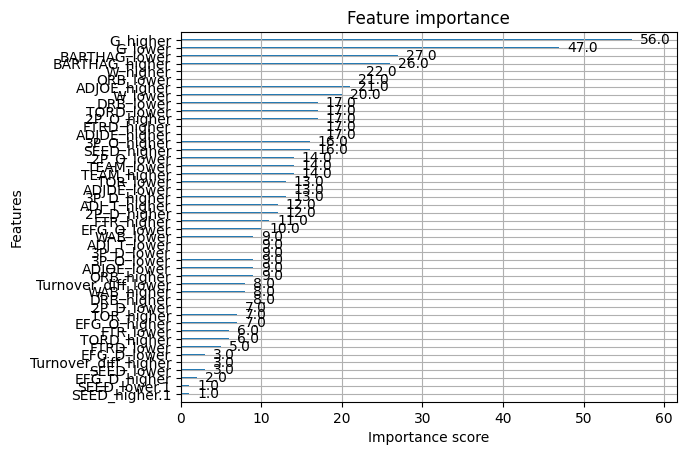

In [7]:
predictions_prob = model.predict(dtest)
predictions = [1 if i > 0.5 else 0 for i in predictions_prob]

print(f"Accuracy: {accuracy_score(y_test, predictions):.4f}")
print(classification_report(y_test, predictions))

cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Higher', 'Lower'])
disp.plot()

xgb.plot_importance(model)

Real Test:

In [8]:
realTest = pd.read_csv('matchups25.csv')
le_test = LabelEncoder()

realTest['TEAM_higher'] = le_test.fit_transform(realTest['TEAM_higher'])
realTest['TEAM_lower'] = le_test.fit_transform(realTest['TEAM_lower'])
test = realTest.drop('winner', axis=1)

dreal = xgb.DMatrix(data=test)

In [ ]:
# XGB Prediction
xgb_test = model.predict(dreal)
real_predictions = ['Lower' if i > 0.5 else 'Higher' for i in xgb_test]
real_predictions